In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import cPickle as pickle

import Stats

In [2]:
def smooth(f, nMax = 3):
    
    length = len(f)
    f1     = np.zeros(length)
    
    for i in range(length):
        iMin = max([i-nMax, 0])
        iMax = min([i+nMax, length])
        f1[i] = np.mean(f[iMin:iMax])
        
    return f1

In [2]:
# Create mean out of a number of samples with different length's
def create_mean(samples):
    i_max = 0
    for s in samples:
        i_max = max(i_max, len(s))
        
    s_mean = np.zeros(i_max)
    n_mean = np.zeros(i_max)
    
    for s in samples:
        s_mean[:len(s)] += s
        n_mean[:len(s)] += 1.
        
    return s_mean/n_mean

In [2]:
# A function that returns X, Y matrices with positions for sample densitus of samples
def get_density_matrix(ylim, samples, n_bins, xlim = None):
    # sample[i] is the i:th sample. Observe that different samples can have different amount
    # of datapoints.
    
    n_iter = 0
    mean_values = []
    for s in samples:
        n_iter = max(len(s), n_iter)
    
    density = np.zeros((n_iter, n_bins))    # Density Matrix
    
    for i in range(n_iter):
        for s in samples:
            value = s[i]
            i_bin = int(n_bins*(value-ylim[0])/(ylim[1]-ylim[0]))
            
            if i_bin >= 0 and i_bin < n_bins:
                density[i, i_bin] += 1.
    
    # Scale after nr of samples
    for i in range(len(density)):
        d_sum = np.sum(density[i])
        
        if d_sum > 0:
            density[i] /= d_sum
    
    if xlim is None:
        xlim = [0, n_iter]
    
    x = np.linspace(xlim[0], xlim[1], n_iter+1)
    y = np.linspace(ylim[0], ylim[1], n_bins+1)
    X,Y = np.meshgrid(x,y)
    
    return X,Y,density.T #, mean_values

##Compilation of results

###FEGB - training

In [3]:
name = ['Deep_Blue', 'Deep_Red', 'n1', 'n2', 'n3']
run  = ['1', '2']

iterations = 1000

stats = []
for n in name:
    for r in run:
        filename = n + '_run' + r + '_it' + str(iterations) + '.pkl'
        pkl_file = open(filename, 'rb')
        data  	 = pickle.load(pkl_file)
        
        stats.append(data[2])

### Compute stuff

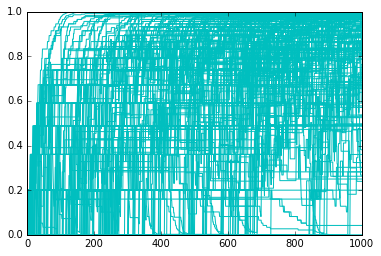

In [11]:
seen_states = []    # Save one list for every run
seen_stact  = []
prob_SA     = []     # Use running mean to compute success prob of a transition
#prob_SA_try = [None]*(len(stats[0].legal_sa)*len(stats))    # Probability of success as a function of attempts (n_SA x n_runs)
prop_S_iter = [200,400,600,800,1000]   # Iterations to check for proportions
prop_S_tot  = [None]*len(prop_S_iter)  # Proportion of time spent in different states

#for i in range(len(prob_SA_try)):
    #prob_SA_try[i] = [0]
    
for i in range(len(prop_S_tot)):
    prop_S_tot[i] = np.zeros(stats[0].n_states)

decay = .8          # Decay-rate for creating a running mean

legal_sa = list(stats[0].legal_sa)

for i_stats in range(len(stats)):
    s = stats[i_stats]
    
    # S-related
    seen_S = np.zeros(s.n_states) # Keep track on what states have been seen
    prop_S = np.zeros(len(s.S_i)) # Proportion of states seen this run
    
    # SA-related
    prob_success = np.zeros((len(s.S_i), len(s.legal_sa))) # n_iter x n_sa
    seen_sa      = np.zeros(len(s.legal_sa))

    #for i in range(len(prop_S)):
    #    print([s.S_i[i],s.S_g[i+1], s.S_f[i]])
    
    for i in range(1,len(prop_S)): # Check for every iteration
        prob_success[i] = prob_success[i-1]
        
        # S-related
        s_i = s.S_i[i-1]
                
        if s_i != -1:
            seen_S[s_i] += 1.  # State s_i was observed
            
            # SA-related
            s_g  = s.S_g[i]   # Unsync with s_i, s_f because programming error
            s_f  = s.S_f[i-1]
            
            sa   = s.get_sa(s_i, s_g)
            i_sa = legal_sa.index(sa) # Index of legal sa attempted
            
            prob_success[i, i_sa] = decay*prob_success[i-1, i_sa]
            if s_g == s_f: # If success
                prob_success[i, i_sa] += 1. - decay
                seen_sa[i_sa] += 1
                
            i_all_sa = i_sa + i_stats*len(s.legal_sa)
            
            #if prob_success[i, i_sa] > 0: # Only look at what happens after initial success
            #prob_SA_try[i_all_sa].append(prob_success[i, i_sa])
            
        #if sa == legal_sa[8]:
        #    print([i, s_i, s_g, s_f])
        
        prop_S[i] = np.mean(seen_S > 0)
        
        if i+1 in prop_S_iter:
            i2 = prop_S_iter.index(i+1)
            prop_S_tot[i2] += seen_S
        
    prob_SA.append(prob_success)    
    seen_states.append(prop_S)
    seen_stact.append(seen_sa)
    
for sa in prob_SA:
    plt.plot(sa, 'c')


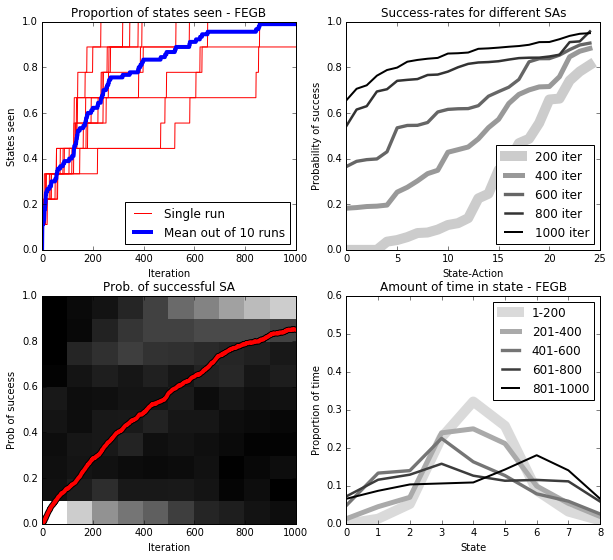

In [26]:
# Plotting
fig = plt.figure(figsize=(10,9))

# Check nr of seen states
fig.add_subplot(221)

for seenS in seen_states:
    plt.plot(seenS, 'r')
    
plt.plot(seenS[0], 'r', label = 'Single run')
plt.plot(np.mean(seen_states, axis = 0), linewidth = 4, label = 'Mean out of 10 runs')
    
plt.legend(loc = 4)
plt.title('Proportion of states seen - FEGB')
plt.xlabel('Iteration')
plt.ylabel('States seen')


# Distribution of state-action success-prob
fig.add_subplot(222)

i_span = [200,400,600,800,1000]
for i in range(len(i_span)):
    
    p = np.zeros(len(legal_sa))
    for p_sa in prob_SA:
        p += p_sa[i_span[i]-1,:]/len(prob_SA)
    
    p = np.sort(p)
        
    c = np.array([1.,1.,1.]) - (i+1.)/len(i_span)
    
    plt.plot(p, linewidth = 10./(i+1), color = c, label = str(i_span[i]) + ' iter')
plt.legend(loc = 0)
plt.ylim([0,1])
plt.title('Success-rates for different SAs')
plt.xlabel('State-Action')
plt.ylabel('Probability of success')

# State-action prob over time
fig.add_subplot(223)

#prob_SA_tot = np.zeros(prob_SA[0].shape)
#for i in range(len(prob_SA)):
#    prob_SA_tot += prob_SA[i]/len(prob_SA)

prob_SA_tot = []
for i in range(len(prob_SA)): # This is the run
    for sa in prob_SA[i].T: # this is the state action
        prob_SA_tot.append(sa)
        
prob_SA_tot = np.array(prob_SA_tot).T

# Only sample at specific iterations
x_step         = 100
i_matrix       = np.array(range(1000/x_step))*x_step + x_step
prob_SA_matrix = np.zeros((len(i_matrix), len(prob_SA_tot.T)))

for i in range(len(i_matrix)):
    i0 = i_matrix[i]-x_step
    i1 = i_matrix[i]
    
    prob_SA_matrix[i] = np.mean(prob_SA_tot[i0:i1], axis = 0)

X,Y,Density = get_density_matrix(xlim = [0, 1000], ylim = [0,1], samples = np.array(prob_SA_matrix).T, n_bins = 1000/x_step)
plt.pcolor(X, Y, np.log(Density+1), cmap='gray')
plt.title('Prob. of successful SA')
plt.xlabel('Iteration')
plt.ylabel('Prob of suceess')

    
#plt.plot(prob_SA_tot, color = [.5,.5,.5])
plt.plot(np.mean(prob_SA_tot, axis = 1), linewidth = 6, color = 'k')
plt.plot(np.mean(prob_SA_tot, axis = 1), linewidth = 4, color = 'r')



# See how distribution of time in different states change with time
fig.add_subplot(224)

for i in range(len(prop_S_iter)):
    if i == 0:
        distr = prop_S_tot[i]
    else:
        distr = prop_S_tot[i] - prop_S_tot[i-1]
        
    distr /= 1.*np.sum(distr)
    
    c = np.array([1.,1.,1.]) - ((i+1.)/len(prop_S_iter))**1.2
    plt.plot(distr, linewidth = 10./(i+1), color = c, label = str(prop_S_iter[i]-199) + '-' + str(prop_S_iter[i]))
    
plt.legend()
plt.title('Amount of time in state - FEGB')
plt.xlabel('State')
plt.ylabel('Proportion of time')
plt.ylim([0,.6])

plt.show()

### Motor babbling - Training

In [6]:
name = ['Deep_Red', 'n1', 'n2']

iterations = 600

stats = []
for n in name:
    filename = n + '_compare_run3_it' + str(iterations) + '.pkl'
    pkl_file = open(filename, 'rb')
    data  	 = pickle.load(pkl_file)
        
    stats.append(data[2])

In [7]:
seen_states = []    # Save one list for every run
seen_stact  = []
prob_SA     = []     # Use running mean to compute success prob of a transition
prob_SA_tot = [None]*(len(stats[0].legal_sa)*len(stats))    # Probability of success as a function of attempts (n_SA x n_runs)
prop_S_iter = [200,400,600]   # Iterations to check for proportions
prop_S_tot  = [None]*len(prop_S_iter)  # Proportion of time spent in different states

for i in range(len(prob_SA_tot)):
    prob_SA_tot[i] = []
    
for i in range(len(prop_S_tot)):
    prop_S_tot[i] = np.zeros(stats[0].n_states)

decay = .8          # Decay-rate for creating a running mean

legal_sa = list(stats[0].legal_sa)

for i_stats in range(len(stats)):
    s = stats[i_stats]
    
    # S-related
    seen_S = np.zeros(s.n_states) # Keep track on what states have been seen
    prop_S = np.zeros(len(s.S_i)) # Proportion of states seen this run
    
    # SA-related
    prob_success = np.zeros((len(s.S_i), len(s.legal_sa)))
    seen_sa      = np.zeros(len(s.legal_sa))

    #for i in range(len(prop_S)):
    #    print([s.S_i[i],s.S_g[i+1], s.S_f[i]])
    
    for i in range(1,len(prop_S)): # Check for every iteration
        prob_success[i] = prob_success[i-1]
        
        # S-related
        s_i = s.S_i[i-1]
                
        if s_i != -1:
            seen_S[s_i] += 1.  # State s_i was observed
            
            # SA-related
            s_g  = s.S_g[i]   # Unsych with s_i, s_f because progrmaming error
            s_f  = s.S_f[i-1]
            
            sa   = s.get_sa(s_i, s_g)
            i_sa = legal_sa.index(sa) # Index of legal sa attempted
            
            prob_success[i, i_sa] = decay*prob_success[i-1, i_sa]
            if s_g == s_f: # If success
                prob_success[i, i_sa] += 1. - decay
                seen_sa[i_sa] += 1
                
            i_all_sa = i_sa + i_stats*len(s.legal_sa)
            
            #if prob_success[i, i_sa] > 0: # Only look at what happens after initial success
            prob_SA_tot[i_all_sa].append(prob_success[i, i_sa])
            
        #if sa == legal_sa[8]:
        #    print([i, s_i, s_g, s_f])
        
        prop_S[i] = np.mean(seen_S > 0)
        
        if i+1 in prop_S_iter:
            i2 = prop_S_iter.index(i+1)
            prop_S_tot[i2] += seen_S
        
    prob_SA.append(prob_success)    
    seen_states.append(prop_S)
    seen_stact.append(seen_sa)
    
print(np.array(prop_S_tot))

[[   5.    3.   23.  131.  309.  107.   16.    1.    2.]
 [   6.    5.   44.  260.  605.  233.   33.    5.    6.]
 [  10.    7.   76.  383.  914.  348.   44.    7.    8.]]


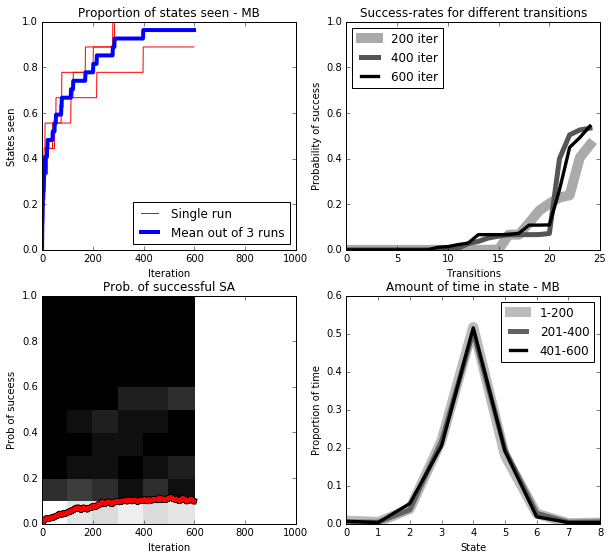

In [13]:
# Plotting
fig = plt.figure(figsize=(10,9))

# Check nr of seen states
fig.add_subplot(221)

for seenS in seen_states:
    plt.plot(seenS, 'r')
    
plt.plot(seenS[0], 'r', label = 'Single run')
plt.plot(np.mean(seen_states, axis = 0), linewidth = 4, label = 'Mean out of 3 runs')
    
plt.legend(loc = 4)
plt.title('Proportion of states seen - MB')
plt.xlabel('Iteration')
plt.ylabel('States seen')
plt.xlim([0,1000])


# Distribution of state-action success-prob
fig.add_subplot(222)

i_span = [200,400,600]
for i in range(len(i_span)):
    
    p = np.zeros(len(legal_sa))
    for p_sa in prob_SA:
        p += p_sa[i_span[i]-1,:]/len(prob_SA)
    
    p = np.sort(p)
        
    c = np.array([1.,1.,1.]) - (i+1.)/len(i_span)
    
    plt.plot(p, linewidth = 10./(i+1), color = c, label = str(i_span[i]) + ' iter')
plt.legend(loc = 2)
plt.ylim([0,1])
plt.title('Success-rates for different transitions')
plt.xlabel('Transitions')
plt.ylabel('Probability of success')

# State-action prob over time
fig.add_subplot(223)

prob_SA_tot = np.zeros(prob_SA[0].shape)
for i in range(len(prob_SA)):
    prob_SA_tot += prob_SA[i]/len(prob_SA)
    
# Only sample at specific iterations
x_step         = 100
i_matrix       = np.array(range(600/x_step))*x_step + x_step
prob_SA_matrix = np.zeros((len(i_matrix), len(stats[0].legal_sa)))

for i in range(len(i_matrix)):
    i0 = i_matrix[i]-x_step
    i1 = i_matrix[i]
    
    prob_SA_matrix[i] = np.mean(prob_SA_tot[i0:i1], axis = 0)

X,Y,Density = get_density_matrix(xlim = [0, 600], ylim = [0,1], samples = np.array(prob_SA_matrix).T, n_bins = 1000/x_step)
plt.pcolor(X, Y, np.log(Density+1), cmap='gray')
plt.title('Prob. of successful SA')
plt.xlabel('Iteration')
plt.ylabel('Prob of suceess')
plt.xlim([0,1000])

    
#plt.plot(prob_SA_tot, color = [.5,.5,.5])
plt.plot(np.mean(prob_SA_tot, axis = 1), linewidth = 6, color = 'k')
plt.plot(np.mean(prob_SA_tot, axis = 1), linewidth = 4, color = 'r')



# See how distribution of time in different states change with time
fig.add_subplot(224)

for i in range(len(prop_S_iter)):
    if i == 0:
        distr = prop_S_tot[i]
    else:
        distr = prop_S_tot[i] - prop_S_tot[i-1]
        
    distr /= 1.*np.sum(distr)
    
    c = np.array([1.,1.,1.]) - ((i+1.)/len(prop_S_iter))**1.2
    plt.plot(distr, linewidth = 10./(i+1), color = c, label = str(prop_S_iter[i]-199) + '-' + str(prop_S_iter[i]))
    
plt.legend()
plt.title('Amount of time in state - MB')
plt.xlabel('State')
plt.ylabel('Proportion of time')
plt.ylim([0,.6])

plt.show()

### FEGB - Testing

In [38]:
name_FEGB  = ['Deep_Red_run1', 'n1_run1', 'n2_run1']
name_MB    = ['Deep_Red_compare_run3', 'n1_compare_run3', 'n2_compare_run3']
names      = [name_FEGB, name_MB]
iterations = [200, 400, 600]
n_states   = 9

prop_S_FEGB = np.zeros((len(iterations), n_states))
prop_S_MB   = np.zeros((len(iterations), n_states))
prop_S      = [prop_S_FEGB, prop_S_MB]

# FEGB or MB
for method in range(2):
    for i in range(len(iterations)):
        for robot in names[method]:
            filename = robot + '_it' + str(iterations[i]) + '_rwalk.pkl'
            pkl_file = open(filename, 'rb')
            data  	 = pickle.load(pkl_file)
            stats    = data[2]
            
            S_i = stats.S_i
            
            for s in range(n_states):
                prop_S[method][i,s] = np.sum(np.array(S_i) == s)

print(prop_S[0])
print(prop_S[1])

'''
# Proportion after 100 steps if starting in s=4
prop_ideal = np.zeros(n_states)

x    = 1.*prop_ideal
x[4] = 1.

# position probability next step
P = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        if abs(i-j) <= 1:
            P[i,j] = 1./3
P[0,0]   = .5
P[0,1]   = .5
P[-1,-1] = .5
P[-1,-2] = .5

n_steps = 100
for i in range(n_steps):
    x = np.matmul(P,x)
    
    prop_ideal += x/n_steps
    plt.plot(prop_ideal/sum(prop_ideal))
plt.show()
'''
print('')

[[  0.   0.   7.  26.  26.  11.  11.   7.  12.]
 [  5.   6.  11.  14.  28.  10.   6.   7.   5.]
 [  8.   5.   6.   3.  22.  13.  10.  14.  17.]]
[[  0.   0.   3.  30.  42.  25.   0.   0.   0.]
 [  0.   0.   0.  13.  65.  22.   0.   0.   0.]
 [  0.   0.   0.   0.  58.  42.   0.   0.   0.]]



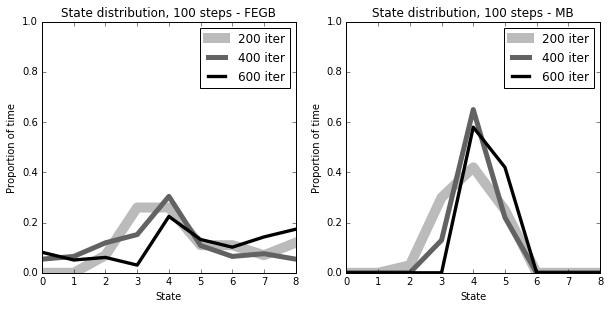

In [39]:
# Plotting
fig = plt.figure(figsize=(10,4.5))

# See how distribution of time in different states change with time
for tmp in [0,1]:
    fig.add_subplot(121 + tmp)

    for i in range(len(iterations)):
        distr  = prop_S[tmp][i]
        distr /= np.sum(distr)

        c = np.array([1.,1.,1.]) - ((i+1.)/len(iterations))**1.2
        plt.plot(distr, linewidth = 10./(i+1), color = c, label = str(iterations[i]) + ' iter')

    plt.legend()
    plt.title('State distribution, 100 steps - ' + ['FEGB', 'MB'][tmp])
    plt.xlabel('State')
    plt.ylabel('Proportion of time')
    plt.ylim([0,1.])

plt.show()